In [61]:
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from keras.optimizers import Adam, SGD, Adagrad, RMSprop
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D , MaxPool2D, Flatten, Dense
from tensorflow.keras import datasets, layers, models
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.models import Model
from matplotlib import pyplot
from sklearn.metrics import ConfusionMatrixDisplay
from numpy import expand_dims
from tensorflow.keras.preprocessing import image_dataset_from_directory
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

#### Reading and normalizing data

In [23]:

train = image_dataset_from_directory(
    'data/train/',
    labels='inferred',
    label_mode='categorical',
    batch_size=1,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    validation_split=0.0
)

val = image_dataset_from_directory(
    'data/val/',
    labels='inferred',
    label_mode='categorical',
    batch_size=1,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    validation_split=0.0
)

test = image_dataset_from_directory(
    'data/test/',
    labels='inferred',
    label_mode='categorical',
    batch_size=1,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    validation_split=0.0
)
class_names = train.class_names
def normalize(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image, label

train_data = train.map(normalize)
val_data = val.map(normalize)
test_data = test.map(normalize)

Found 250 files belonging to 5 classes.
Found 50 files belonging to 5 classes.
Found 100 files belonging to 5 classes.


#### Arch 1

In [15]:
input_layer = layers.Input(shape=(224, 224, 3))
conv1 = layers.Conv2D(8, (11, 11), strides=4, padding='same', activation='relu')(input_layer)
max_pool1 = layers.MaxPooling2D((3, 3), strides=(2, 2))(conv1)
conv2 = layers.Conv2D(16, (5, 5), strides=1, padding='same', activation='relu')(max_pool1)
max_pool2 = layers.MaxPooling2D((3, 3), strides=2)(conv2)
flatten = layers.Flatten()(max_pool2)
dense1 = layers.Dense(128, activation='relu')(flatten)
output_layer = layers.Dense(5, activation ='softmax')(dense1)

adam_optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
# model.compile(optimizer=adam_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model = models.Model(inputs=input_layer, outputs=output_layer)

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=0), optimizer=adam_optimizer, metrics=['accuracy'])

# callbacks
my_callbacks = [
    EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10),
    TensorBoard(log_dir=f'./logdir/Q1/Arch1/')
]
# out = model.fit(train_data, validation_data=val_data, epochs=100, callbacks=my_callbacks)
model_fit = model.fit(train_data,validation_data=val_data, batch_size=len(train_data), epochs=100, verbose=0, callbacks=my_callbacks, validation_split=0.0, shuffle=True, validation_batch_size=None)

hist_metric = 'accuracy'
print(f'epochs: {len(model_fit.history[hist_metric])}, acc: {model_fit.history[hist_metric][-1]}\n')
model.save(f'models/Q1/Arch1.tf')


epochs: 17, acc: 0.9760000109672546



Plotting accuracy

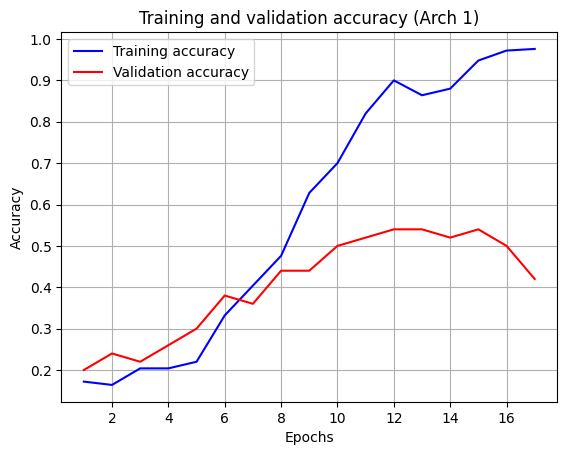

In [26]:
# Plot accuracy history
acc = model_fit.history['accuracy']
val_acc = model_fit.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.figure()
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy (Arch 1)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Plotting confusion matrix

In [62]:
# train accuracy and confusion matrix
train_loss, train_acc = model.evaluate(train_data, verbose=0)
train_pred = model.predict(train_data)
train_labels = tf.concat([q for p, q in train_data], axis=0)
print("Confusion Matrix:")
print(tf.math.confusion_matrix(tf.argmax(train_labels,axis=1),tf.argmax(train_pred,axis=1),num_classes=5))
# val accuracy and confusion matrix
val_loss, val_acc = model.evaluate(val_data, verbose=0)
val_pred = model.predict(val_data)
val_labels = tf.concat([q for p, q in val_data], axis=0)
print("Confusion Matrix:")
print(tf.math.confusion_matrix(tf.argmax(val_labels,axis=1),tf.argmax(val_pred,axis=1),num_classes=5))

250/250 [==============================] - 0s 2ms/step
Confusion Matrix:
tf.Tensor(
[[ 4 21  9  8  8]
 [ 6 16 10  7 11]
 [ 4  7 16 14  9]
 [ 9 14  5 13  9]
 [ 3 14  8 13 12]], shape=(5, 5), dtype=int32)
50/50 [==============================] - 0s 2ms/step
Confusion Matrix:
tf.Tensor(
[[0 6 3 0 1]
 [0 4 3 1 2]
 [1 2 3 2 2]
 [0 5 1 2 2]
 [0 2 3 3 2]], shape=(5, 5), dtype=int32)


250/250 [==============================] - 0s 2ms/step
50/50 - 0s - loss: 3.3953 - accuracy: 0.4200 - 119ms/epoch - 2ms/step
50/50 [==============================] - 0s 2ms/step
Confusion matrix (train):


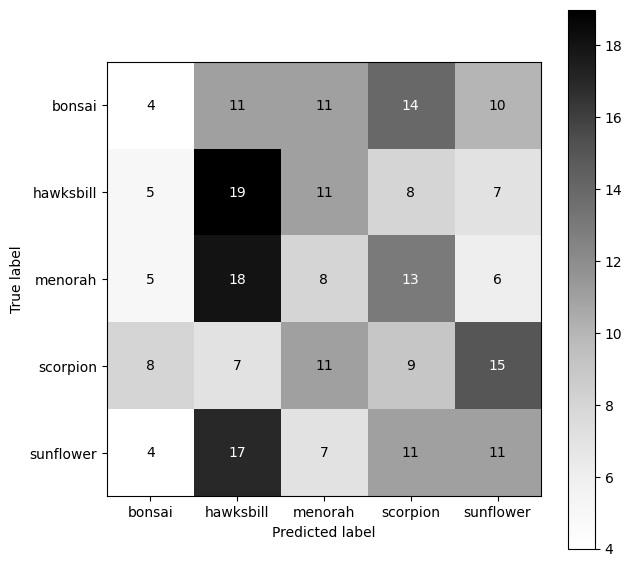

Confusion matrix (val):


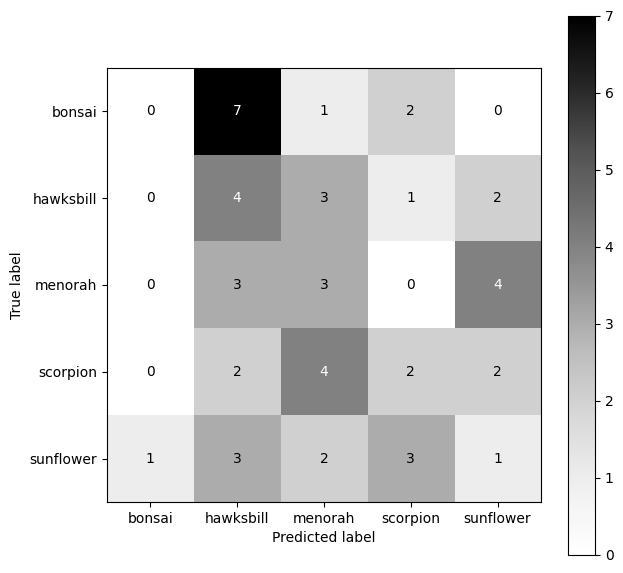

In [64]:
train_loss, train_acc = model.evaluate(train_data, verbose=0)
train_pred = model.predict(train_data)
train_labels = tf.concat([q for p, q in train_data], axis=0)

val_loss, val_acc = model.evaluate(val_data, verbose=2)
val_pred = model.predict(val_data)
val_labels = tf.concat([q for p, q in val_data], axis=0)

print('Confusion matrix (train):')
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(tf.argmax(train_labels,axis=1),tf.argmax(train_pred,axis=1)), display_labels=class_names)
cm_display.plot(ax = ax, cmap='Greys', colorbar=True)
plt.show()

print('Confusion matrix (val):')
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(tf.argmax(val_labels,axis=1),tf.argmax(val_pred,axis=1)), display_labels=class_names)
cm_display.plot(ax = ax, cmap='Greys', colorbar=True)
plt.show()

#### Arch 2

In [65]:
input_layer = layers.Input(shape=(224, 224, 3))
conv1 = layers.Conv2D(8, (11, 11), strides=4, padding='same', activation='relu')(input_layer)
max_pool1 = layers.MaxPooling2D((3, 3), strides=(2, 2))(conv1)
conv2 = layers.Conv2D(16, (5, 5), strides=1, padding='same', activation='relu')(max_pool1)
max_pool2 = layers.MaxPooling2D((3, 3), strides=2)(conv2)
conv3 = layers.Conv2D(32, (3, 3), strides=1, padding='same', activation='relu')(max_pool2)
max_pool3 = layers.MaxPooling2D((3,3), strides=2)(conv3)
flatten = layers.Flatten()(max_pool3)
dense1 = layers.Dense(128, activation='relu')(flatten)
output_layer = layers.Dense(5, activation ='softmax')(dense1)

adam_optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
# model.compile(optimizer=adam_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model = models.Model(inputs=input_layer, outputs=output_layer)

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=0), optimizer=adam_optimizer, metrics=['accuracy'])

# callbacks
my_callbacks = [
    EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10),
    TensorBoard(log_dir=f'./logdir/Q1/Arch2/')
]
# out = model.fit(train_data, validation_data=val_data, epochs=100, callbacks=my_callbacks)
model_fit = model.fit(train_data,validation_data=val_data, batch_size=len(train_data), epochs=100, verbose=0, callbacks=my_callbacks, validation_split=0.0, shuffle=True, validation_batch_size=None)

hist_metric = 'accuracy'
print(f'epochs: {len(model_fit.history[hist_metric])}, acc: {model_fit.history[hist_metric][-1]}\n')
model.save(f'models/Q1/Arch2.tf')


epochs: 15, acc: 0.9959999918937683



Plotting accuracy

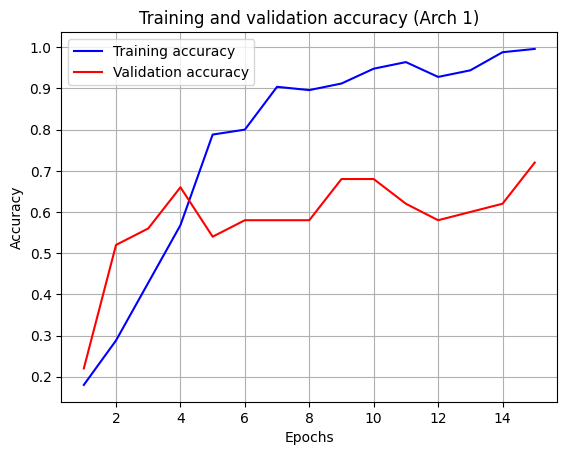

In [66]:
# Plot accuracy history
acc = model_fit.history['accuracy']
val_acc = model_fit.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.figure()
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy (Arch 1)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Plotting confusion matrix

In [67]:
# train accuracy and confusion matrix
train_loss, train_acc = model.evaluate(train_data, verbose=0)
train_pred = model.predict(train_data)
train_labels = tf.concat([q for p, q in train_data], axis=0)
print("Confusion Matrix:")
print(tf.math.confusion_matrix(tf.argmax(train_labels,axis=1),tf.argmax(train_pred,axis=1),num_classes=5))
# val accuracy and confusion matrix
val_loss, val_acc = model.evaluate(val_data, verbose=0)
val_pred = model.predict(val_data)
val_labels = tf.concat([q for p, q in val_data], axis=0)
print("Confusion Matrix:")
print(tf.math.confusion_matrix(tf.argmax(val_labels,axis=1),tf.argmax(val_pred,axis=1),num_classes=5))

250/250 [==============================] - 0s 2ms/step
Confusion Matrix:
tf.Tensor(
[[ 8 12  8 10 12]
 [ 8 10  9 13 10]
 [ 7  9 13 12  9]
 [15 10 10  8  7]
 [12  9 10  7 12]], shape=(5, 5), dtype=int32)
50/50 [==============================] - 0s 3ms/step
Confusion Matrix:
tf.Tensor(
[[2 1 2 5 0]
 [2 2 1 2 3]
 [0 3 1 3 3]
 [1 3 0 5 1]
 [2 2 3 2 1]], shape=(5, 5), dtype=int32)


250/250 [==============================] - 0s 1ms/step
50/50 - 0s - loss: 1.5754 - accuracy: 0.7200 - 108ms/epoch - 2ms/step
50/50 [==============================] - 0s 2ms/step
Confusion matrix (train):


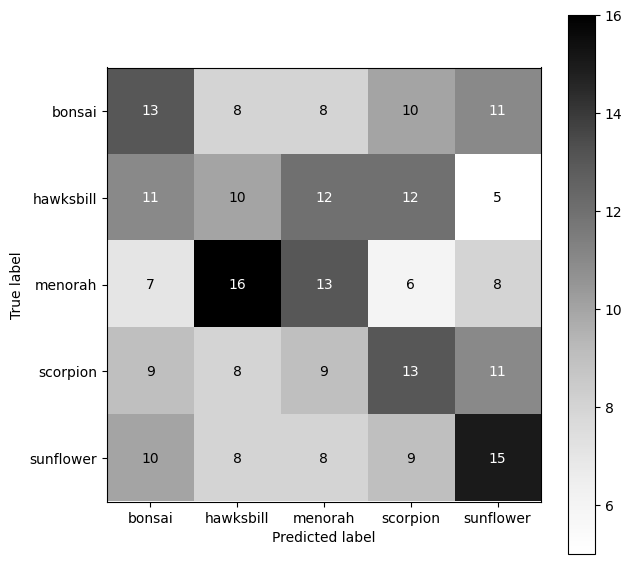

Confusion matrix (val):


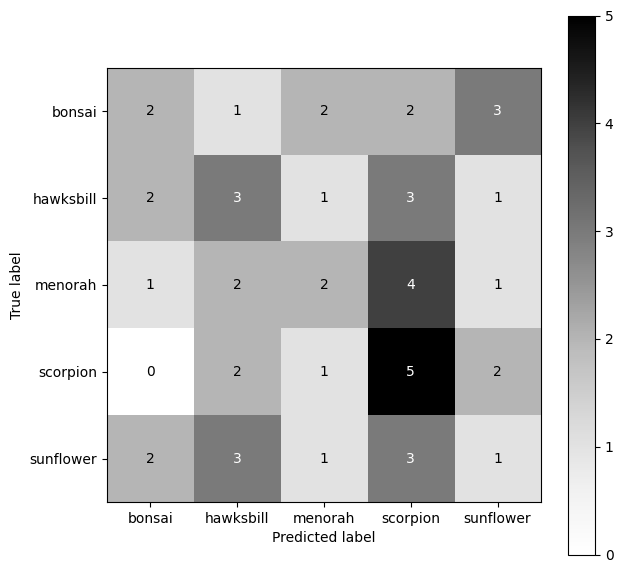

In [68]:
train_loss, train_acc = model.evaluate(train_data, verbose=0)
train_pred = model.predict(train_data)
train_labels = tf.concat([q for p, q in train_data], axis=0)

val_loss, val_acc = model.evaluate(val_data, verbose=2)
val_pred = model.predict(val_data)
val_labels = tf.concat([q for p, q in val_data], axis=0)

print('Confusion matrix (train):')
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(tf.argmax(train_labels,axis=1),tf.argmax(train_pred,axis=1)), display_labels=class_names)
cm_display.plot(ax = ax, cmap='Greys', colorbar=True)
plt.show()

print('Confusion matrix (val):')
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(tf.argmax(val_labels,axis=1),tf.argmax(val_pred,axis=1)), display_labels=class_names)
cm_display.plot(ax = ax, cmap='Greys', colorbar=True)
plt.show()

#### Arch 3

In [71]:
input_layer = layers.Input(shape=(224, 224, 3))
conv1 = layers.Conv2D(8, (11, 11), strides=4, padding='same', activation='relu')(input_layer)
max_pool1 = layers.MaxPooling2D((3, 3), strides=(2, 2))(conv1)
conv2 = layers.Conv2D(16, (5, 5), strides=1, padding='same', activation='relu')(max_pool1)
max_pool2 = layers.MaxPooling2D((3, 3), strides=2)(conv2)
conv3 = layers.Conv2D(32, (3, 3), strides=1, padding='same', activation='relu')(max_pool2)
conv4 = layers.Conv2D(64, (3, 3), strides=1, padding='same', activation='relu')(conv3)
max_pool3 = layers.MaxPooling2D((3, 3), strides=2)(conv4)
flatten = layers.Flatten()(max_pool3)
dense1 = layers.Dense(128, activation='relu')(flatten)
output_layer = layers.Dense(5, activation ='softmax')(dense1)

adam_optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
# model.compile(optimizer=adam_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model = models.Model(inputs=input_layer, outputs=output_layer)

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=0), optimizer=adam_optimizer, metrics=['accuracy'])

# callbacks
my_callbacks = [
    EarlyStopping(monitor='val_loss', min_delta=1e-7, patience=10),
    TensorBoard(log_dir=f'./logdir/Q1/Arch3/')
]
# out = model.fit(train_data, validation_data=val_data, epochs=100, callbacks=my_callbacks)
model_fit = model.fit(train_data,validation_data=val_data, batch_size=len(train_data), epochs=100, verbose=0, callbacks=my_callbacks, validation_split=0.0, shuffle=True, validation_batch_size=None)

hist_metric = 'accuracy'
print(f'epochs: {len(model_fit.history[hist_metric])}, acc: {model_fit.history[hist_metric][-1]}\n')
model.save(f'models/Q1/Arch3.tf')


epochs: 22, acc: 1.0



Plotting accuracy

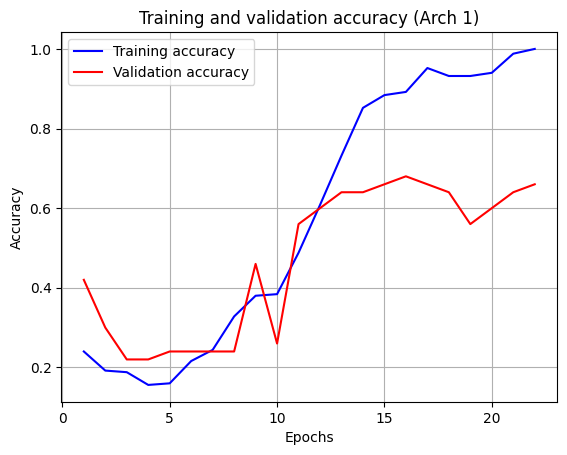

In [72]:
# Plot accuracy history
acc = model_fit.history['accuracy']
val_acc = model_fit.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.figure()
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy (Arch 1)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Plotting confusion matrix

In [73]:
# train accuracy and confusion matrix
train_loss, train_acc = model.evaluate(train_data, verbose=0)
train_pred = model.predict(train_data)
train_labels = tf.concat([q for p, q in train_data], axis=0)
print("Confusion Matrix:")
print(tf.math.confusion_matrix(tf.argmax(train_labels,axis=1),tf.argmax(train_pred,axis=1),num_classes=5))
# val accuracy and confusion matrix
val_loss, val_acc = model.evaluate(val_data, verbose=0)
val_pred = model.predict(val_data)
val_labels = tf.concat([q for p, q in val_data], axis=0)
print("Confusion Matrix:")
print(tf.math.confusion_matrix(tf.argmax(val_labels,axis=1),tf.argmax(val_pred,axis=1),num_classes=5))

250/250 [==============================] - 1s 2ms/step
Confusion Matrix:
tf.Tensor(
[[13  9 10 10  8]
 [12 13  7 10  8]
 [10  9 11 13  7]
 [ 7  7 13 11 12]
 [ 8 12  9  6 15]], shape=(5, 5), dtype=int32)
50/50 [==============================] - 0s 3ms/step
Confusion Matrix:
tf.Tensor(
[[0 2 2 6 0]
 [2 2 1 3 2]
 [2 2 3 1 2]
 [0 5 2 2 1]
 [3 0 3 2 2]], shape=(5, 5), dtype=int32)


250/250 [==============================] - 0s 2ms/step
50/50 - 0s - loss: 2.4780 - accuracy: 0.6600 - 113ms/epoch - 2ms/step
50/50 [==============================] - 0s 2ms/step
Confusion matrix (train):


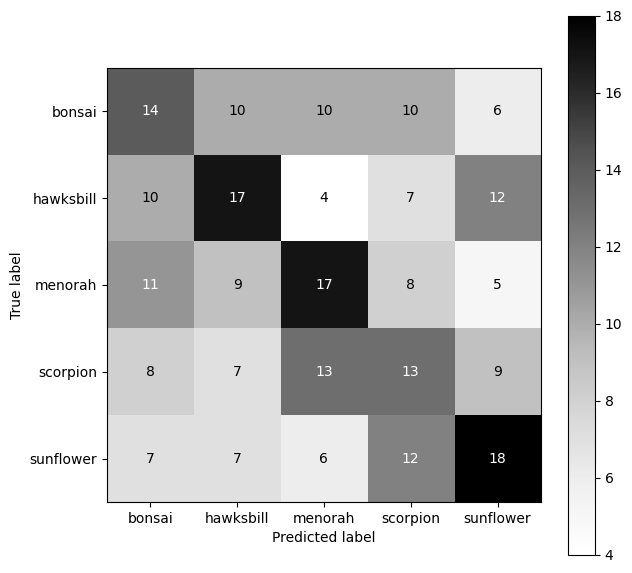

Confusion matrix (val):


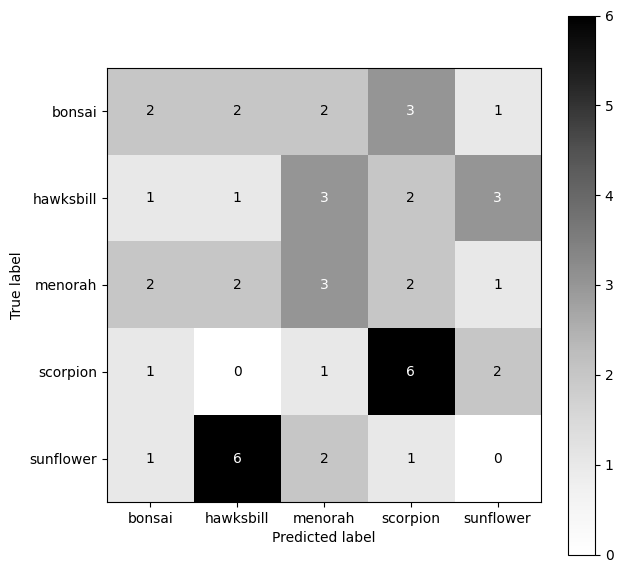

In [74]:
train_loss, train_acc = model.evaluate(train_data, verbose=0)
train_pred = model.predict(train_data)
train_labels = tf.concat([q for p, q in train_data], axis=0)

val_loss, val_acc = model.evaluate(val_data, verbose=2)
val_pred = model.predict(val_data)
val_labels = tf.concat([q for p, q in val_data], axis=0)

print('Confusion matrix (train):')
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(tf.argmax(train_labels,axis=1),tf.argmax(train_pred,axis=1)), display_labels=class_names)
cm_display.plot(ax = ax, cmap='Greys', colorbar=True)
plt.show()

print('Confusion matrix (val):')
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(tf.argmax(val_labels,axis=1),tf.argmax(val_pred,axis=1)), display_labels=class_names)
cm_display.plot(ax = ax, cmap='Greys', colorbar=True)
plt.show()

#### Feature maps for best architecture

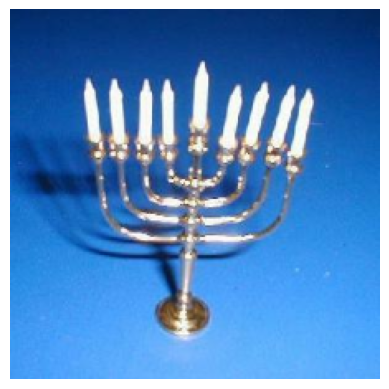

In [107]:
image = [image.numpy() for image, label in train_data.take(1)][0]
plt.imshow(image[0])
plt.axis(False)
plt.show()

(1, 224, 224, 3)
1/1 [==============================] - 0s 34ms/step


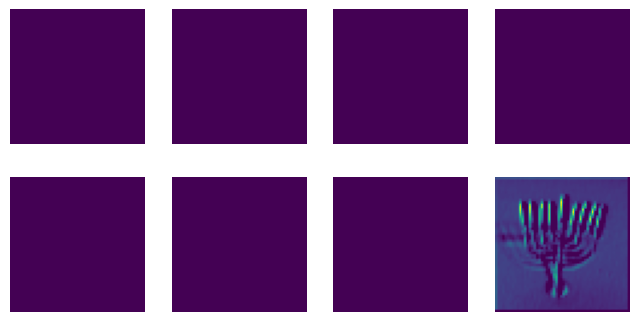

(1, 224, 224, 3)
1/1 [==============================] - 0s 73ms/step


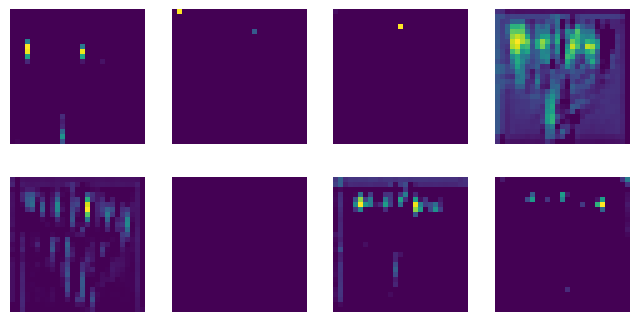

(1, 224, 224, 3)
1/1 [==============================] - 0s 43ms/step


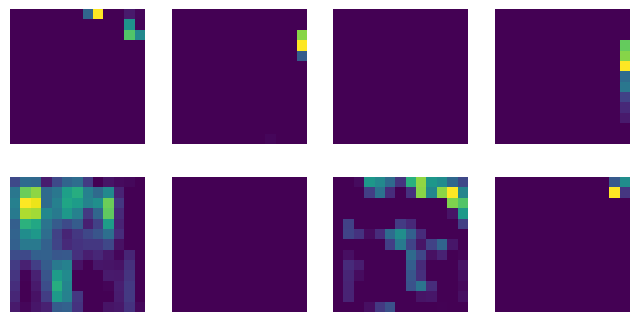

In [133]:
# feature maps
for i in [1,3,5]:
    part_model = Model(inputs=model.inputs, outputs=model.layers[i].output)
    # get feature map for first hidden layer
    print(image.shape)
    feature_maps = part_model.predict(image)

    fig, ax = plt.subplots(2,4, figsize=(8,4))
    for j in range(8):
        ax[int(j/4)][int(j%4)].imshow(feature_maps[0, :, :, j],'viridis')
        ax[int(j/4)][int(j%4)].axis("off")
    plt.axis("off")
    plt.show()

#### Maximally activating patch

In [ ]:
img_normalized = image

In [ ]:
def find_max(arr):
    return np.unravel_index(np.argmax(arr), arr.shape)[1:-1]
def trace(left_idx, right_idx, layer_idx, model):
    top_left = left_idx
    bottom_right = right_idx
    for i in range(layer_idx, 0, -1):
        layer = model.layers[i]
        c = layer.kernel_size[0] if isinstance(model.layers[i], Conv2D) else layer.pool_size[0]
        s = layer.strides[0]
        l_i, l_j = top_left
        r_i, r_j = bottom_right
        top_left = s * l_i, s * l_j
        bottom_right = s * r_i + (c-1), s * r_j + (c-1)
    
    return top_left, bottom_right

new_model = Model(inputs = model.input, outputs = model.layers[4].output)
# fig, axes = plt.subplots(nrows = 5, ncols = 1)
images = []
for a, class_name in enumerate(class_names):
    output = new_model.predict(np.array([img_normalized]))
    mx_neuron = find_max(output)
    left_idx, right_idx = trace(mx_neuron, mx_neuron, 4, new_model)
    print(left_idx, right_idx)
    cropped_img = img.copy()
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            l_i, l_j = left_idx
            r_i, r_j = right_idx
            if(i < l_i or j < l_j or i > r_i or j > r_j):
                cropped_img[i,j,:] //=2
            elif(i == l_i or i == r_i or j == l_j or j == r_j):
                cropped_img[i,j,:] = 255
    plt.imshow(cropped_img)
    plt.show()

In [135]:
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_23 (Conv2D)          (None, 56, 56, 8)         2912      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 27, 27, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 27, 27, 16)        3216      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 13, 13, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 13, 13, 32)        4640

In [138]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

images = image

# Pass each image through the CNN model and obtain the predicted class probabilities
probs = model.predict(images)

# Identify the index of the neuron in the last convolutional layer that has the maximum activation for each image
last_conv_layer = model.get_layer('conv2d_26')
for i in range(1):
    class_idx = np.argmax(probs[i])
    max_activation = tf.reduce_max(model.output[:, class_idx])
    grads = tf.GradientTape(max_activation, last_conv_layer.output)[0]
    pooled_grads = tf.keras.backend.mean(grads, axis=(0, 1, 2))
    iterate = tf.keras.backend.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([np.expand_dims(images[i], axis=0)])
    for j in range(conv_layer_output_value.shape[-1]):
        if np.argmax(pooled_grads_value) == j:
            heatmap = conv_layer_output_value[:, :, j]
            break

    # Backtrack from the neuron to the input image to find the patch that causes the neuron to fire
    heatmap = cv2.resize(heatmap.numpy(), (images[i].shape[1], images[i].shape[0]))
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(images[i], 0.6, heatmap, 0.4, 0)

    # Visualize the patches in each of the images that maximally activate the identified neuron
    fig, ax = plt.subplots(1, 3)
    ax[0].imshow(images[i])
    ax[0].set_title('Input Image')
    ax[1].imshow(heatmap)
    ax[1].set_title('Heatmap')


1/1 [==============================] - 0s 21ms/step


TypeError: 'GradientTape' object is not subscriptable